In [16]:
import tensorflow as tf
import numpy as np

<h2> Load Model and Image samples</h2>

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
['paper' 'rock' 'scissors']
Corresponding label : paper


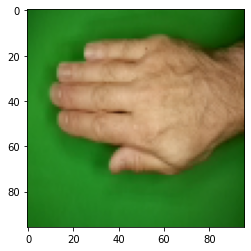

In [17]:
%load_ext autoreload
%autoreload 2

from utilities.script.image_utils import load_samples, show_image_number
from utilities.script.image_utils import show_classification_result

# Load image sample
sample_images, sample_ground_truth = load_samples(size=(96, 96))
show_image_number(sample_images[0], sample_ground_truth[0])

In [18]:
# Convert to categorical

sample_ground_truth_categorical = tf.keras.utils.to_categorical(sample_ground_truth, num_classes=3)

In [19]:
# Load Model
MODEL_PATH = "weight/shallow/"
SAVED_WEIGHT_NAME = "shallow_4.h5"
SAVED_CONFIGURATION_NAME = "shallow_4.json"

json_file = open(MODEL_PATH + SAVED_CONFIGURATION_NAME, 'r')
loaded_model_json = json_file.read()
json_file.close()
classifier = tf.keras.models.model_from_json(loaded_model_json)


classifier.load_weights(MODEL_PATH + SAVED_WEIGHT_NAME)

classifier.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 96, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 24, 24, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 12, 12, 16)       0

In [20]:
# First pertubation towards pixel x,y coordinates and RGB values
def perturb_image(xs, image):
    if xs.ndim < 2:
        xs = np.array([xs])

    # Copy the image n == len(xs) times so that we can 
    # create n new perturbed images
    tile = [len(xs)] + [1] * (xs.ndim+1)
    images = np.tile(image, tile)

    xs = xs.astype(int)

    for x, img in zip(xs, images):
        pixels = np.split(x, len(x) // 5)
        for pixel in pixels:
            x_pos, y_pos, *rgb = pixel
            img[x_pos, y_pos] = rgb

    return images

In [21]:
sample_images.shape

(9, 96, 96, 3)

<h2> Testing with Early Perturbations </h2>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


['paper' 'rock' 'scissors']
Corresponding label : rock


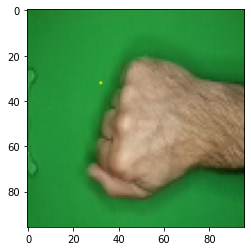

In [22]:
SAMPLE_INDEX = 3
# Perturb the sample with yellow pixel
pixel = np.array([32, 32, 255, 255, 0]) # pixel x,y and RGB
image_perturbed = perturb_image(pixel, sample_images[SAMPLE_INDEX])[0]

show_image_number(image_perturbed, sample_ground_truth[SAMPLE_INDEX])

In [23]:
def predict_perturbed_class(xs, image, model):
    perturbed_image = perturb_image(xs, image)
    predictions = model.predict(perturbed_image)

    confidence = max(predictions[0])
    predicted_class = np.argmax(predictions[0])

    print("Confidence : {} and Predicted Class : {}".format(confidence, predicted_class))

    return predicted_class

def predict_class(image, model):
    image = np.expand_dims(image, axis=0)

    predictions = model.predict(image)
    confidence = max(predictions[0])
    predicted_class = np.argmax(predictions[0])

    print("Confidence : {} and Predicted Class : {}".format(confidence, predicted_class))

def predict_perturb_minimize(xs, image, target_class, model, minimize=True):
    perturbed_image = perturb_image(xs, image)
    predictions = model.predict(perturbed_image)[:, target_class]
    
    return predictions if minimize else 1 - predictions

In [24]:
# Sample ground truth
print("Sample Ground Truth : {}" .format(sample_ground_truth[SAMPLE_INDEX]))

# Perturbed Image
print("Perturbed Result : ")
predict_perturbed_class(pixel, sample_images[SAMPLE_INDEX], classifier)

print("Non Perturbed Result : ")
predict_class(sample_images[SAMPLE_INDEX], classifier)

Sample Ground Truth : 1
Perturbed Result : 
1/1 [==============================] - 0s 71ms/step
Confidence : 0.947821319103241 and Predicted Class : 2
Non Perturbed Result : 
1/1 [==============================] - 0s 19ms/step
Confidence : 1.0 and Predicted Class : 1


<h2> Define When the attacking scenario is succeed</h2>

In [25]:
def attack_success(xs, img, target_class, model, targeted_attack=False):
    # Create early one-pixel perturbation
    attack_image = perturb_image(xs, img)

    # Obtain the predicted class
    confidence = model.predict(attack_image)[0]
    predicted_class = np.argmax(confidence)

    if ((targeted_attack and predicted_class == target_class)) or (not targeted_attack and predicted_class != target_class):
        return True

In [26]:
success = attack_success(pixel, sample_images[SAMPLE_INDEX], sample_ground_truth[SAMPLE_INDEX], classifier)

print("Attack Success : {}".format(success))
predict_perturbed_class(pixel, sample_images[SAMPLE_INDEX], classifier)

1/1 [==============================] - 0s 18ms/step
Attack Success : True
1/1 [==============================] - 0s 21ms/step
Confidence : 0.947821319103241 and Predicted Class : 2


2

In [27]:
%load_ext autoreload
%autoreload 2
from one_pixel_attack_keras.differential_evolution import differential_evolution

def attack(img_id, model, target=None, pixel_count=1, maxiter=75, popsize=400, verbose=False):
    # Change the target class based on whether this is a targeted attack or not
    targeted_attack = target is not None
    target_class = target if targeted_attack else sample_ground_truth[img_id]

    bounds = [(0,32), (0,32), (0,256), (0,256), (0,256)] * pixel_count

    popmul = max(1, popsize//len(bounds))

    def predict_fn(xs):
        return predict_perturb_minimize(xs, sample_images[img_id], sample_ground_truth[img_id], model, target is None)
    
    def callback_fn(xs, convergence):
        return attack_success(xs, sample_images[img_id], target_class, model, targeted_attack)
    
    attack_result = differential_evolution(predict_fn, bounds, maxiter=maxiter, popsize=popmul, recombination=1, atol=-1, callback=callback_fn, polish=False)

    # Get Information whether the perturbed image was succeed
    attack_image = perturb_image(attack_result.x, sample_images[img_id])
    ground_truth = sample_ground_truth[img_id]
    success = predict_class != ground_truth

    predicted_confidence = model.predict(attack_image)[0]
    predicted_class = np.argmax(predicted_confidence)

    return attack_image, (success, ground_truth, predicted_class), predicted_confidence

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:

from utilities.script.image_utils import show_classification_result

real_images = []
real_images_labels = []

adversary_images = []
adversary_images_labels = []

for idx, img in enumerate(sample_images):
    perturbed_image, predict_information, confidence = attack(idx, classifier, pixel_count=1, verbose=False)
    temp_img = np.expand_dims(sample_images[idx], axis=0)
    predict_real = classifier.predict(temp_img)[0]

    real_images.append(sample_images[idx])
    real_images_labels.append(predict_real)

    adversary_images.append(perturbed_image[0])
    adversary_images_labels.append(confidence)


1/1 [==============================] - 0s 19ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


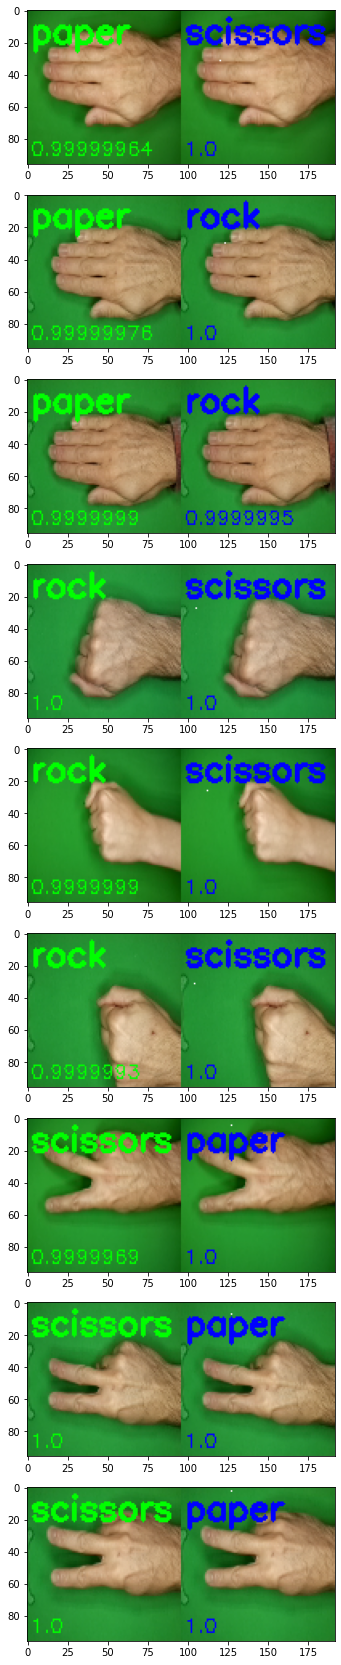

In [29]:
show_classification_result(images=real_images, adversaries=adversary_images, labels=real_images_labels, adversary_labels=adversary_images_labels)